# Imports

In [5]:
# !pip install missingno

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import pandas as pd
import missingno as mnso
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import boxcox
from scipy.special import boxcox1p


In [8]:
# folder = '/kaggle/input/playground-series-s4e12/'
folder = './data/playground-series-s4e12/'


X_train = pd.read_csv(f'{folder}train.csv')
X_test = pd.read_csv(f'{folder}test.csv')
sample_submission = pd.read_csv(f'{folder}sample_submission.csv')

X_train = X_train.drop(['id'], axis=1)

id_test = X_test.id
X_test = X_test.drop('id', axis=1)
X_train.shape , X_test.shape, sample_submission.shape, X_train.columns, X_test.columns

((1200000, 20),
 (800000, 19),
 (800000, 2),
 Index(['Age', 'Gender', 'Annual Income', 'Marital Status',
        'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
        'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
        'Credit Score', 'Insurance Duration', 'Policy Start Date',
        'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
        'Property Type', 'Premium Amount'],
       dtype='object'),
 Index(['Age', 'Gender', 'Annual Income', 'Marital Status',
        'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
        'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
        'Credit Score', 'Insurance Duration', 'Policy Start Date',
        'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
        'Property Type'],
       dtype='object'))

In [9]:
X_train.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [19]:
sample_submission.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


# EDA

In [11]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        print(f'{X_train[col].value_counts()} , unique values: {X_train[col].nunique()}')


Gender
Male      602571
Female    597429
Name: count, dtype: int64 , unique values: 2
Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64 , unique values: 3
Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64 , unique values: 4
Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64 , unique values: 3
Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64 , unique values: 3
Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64 , unique values: 3
Policy Start Date
2020-02-08 15:21:39.134960    142
2023-08-13 15:21:39.155231    137
2022-02-02 15:21:39.134960    137
2022-08-30 15:21:39.134960    134
2023-11-02 15:21:39.134960    118
                             ... 
2021-06-07 15:21:39.104139      1
2024-07-19 15:21:39.2339

In [32]:
print('missing values')
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        print(f'{col:25}  {X_test[col].isnull().sum():10} {X_test[col].isnull().sum():10} (unique values: {X_test[col].nunique()})')

missing values
Gender                              0          0 (unique values: 2)
Marital Status                  12336      12336 (unique values: 3)
Education Level                     0          0 (unique values: 4)
Occupation                     239125     239125 (unique values: 3)
Location                            0          0 (unique values: 3)
Policy Type                         0          0 (unique values: 3)
Policy Start Date                   0          0 (unique values: 158776)
Customer Feedback               52276      52276 (unique values: 3)
Smoking Status                      0          0 (unique values: 2)
Exercise Frequency                  0          0 (unique values: 4)
Property Type                       0          0 (unique values: 3)


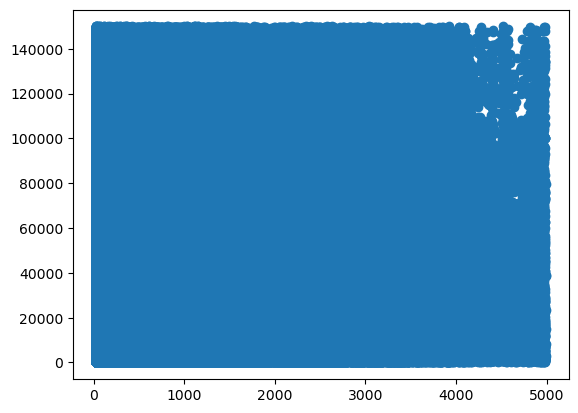

In [23]:
plt.scatter(X_train['Premium Amount'], X_train['Annual Income'])

<Axes: xlabel='Premium Amount', ylabel='Density'>

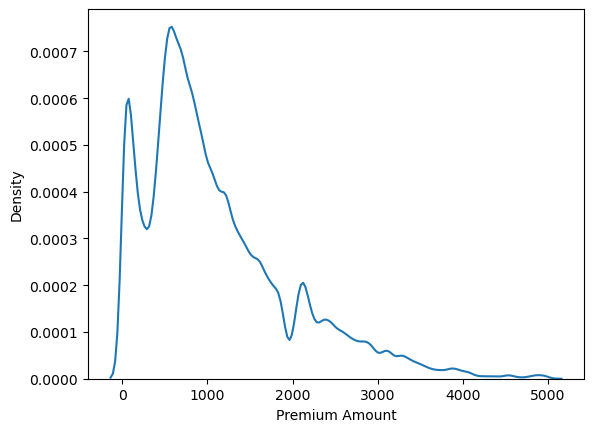

In [24]:
sns.kdeplot(X_train['Premium Amount'])

<Axes: xlabel='Annual Income', ylabel='Density'>

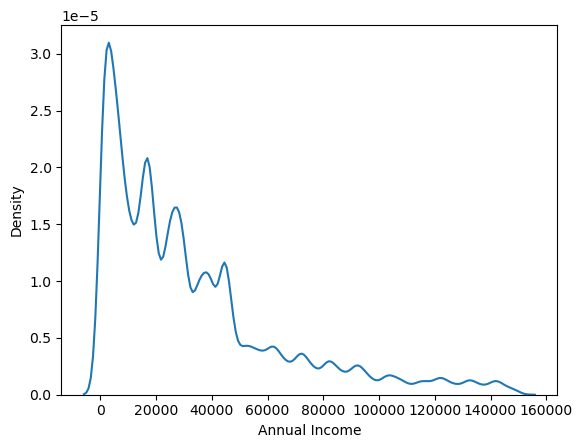

In [25]:
sns.kdeplot(X_train['Annual Income'])

In [26]:
X_train['Annual Income'] = np.log1p(X_train['Annual Income'])
X_test['Annual Income'] = np.log1p(X_test['Annual Income'])

<Axes: xlabel='Annual Income', ylabel='Density'>

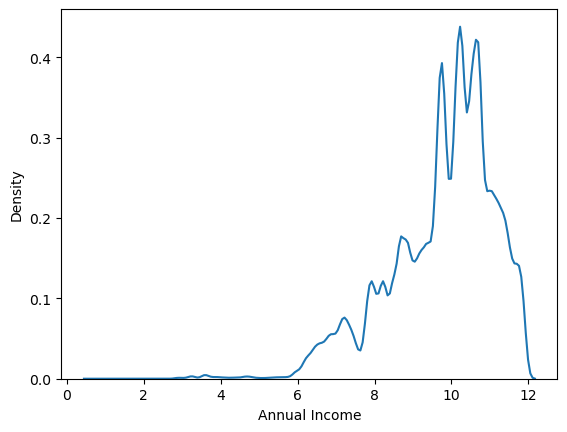

In [27]:
sns.kdeplot(X_train['Annual Income'])

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-

In [33]:
def date(df):

    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df.drop('Policy Start Date', axis=1, inplace=True)

    return df

X_train = date(X_train)
X_test = date(X_test)

In [34]:
numerical_features = [
    'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 
    'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 
    'Year_sin', 'Year_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos'
]
categorical_features = [
    'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
    'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 
    'Property Type', 'Month_name', 'Day_of_week'
]
target_column = 'Premium Amount'

In [35]:
X = X_train.drop(columns=[target_column, 'id', 'Group', 'Year', 'Month', 'Day', 'Week'] , errors='ignore')
y = X_train[target_column]
X.shape, y.shape

((1200000, 26), (1200000,))

In [36]:
# Preprocessing pipeline for numerical features
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())                       # Scale numerical features
])

# Preprocessing pipeline for categorical features
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                      # Encode categorical features
])

# Combine pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ]
)

# Preprocess train and test data
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(X_test.drop(columns=['id', 'Group', 'Year', 'Month', 'Day', 'Week'], errors='ignore'))

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((960000, 64), (240000, 64), (960000,), (240000,))

In [ ]:
X_test  = test_processed.drop('Premium Amount', axis=1)

# Models 

In [43]:
# linear regression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}')

LinearRegression()

RMSE: 861.4984481107421


In [44]:
# random forest
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}')

RandomForestRegressor(random_state=42)

RMSE: 849.6985545275724


In [45]:
# from sklearn.metrics import root_mean_squared_log_error,mean_squared_error, mean_absolute_error, r2_score

# # Calcul des métriques
# rmsle = root_mean_squared_log_error(y_val, y_pred)
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# mae = mean_absolute_error(y_val, y_pred)
# r2 = r2_score(y_val, y_pred)
# mape = np.mean(np.abs((y_val - y_pred) / y)) * 100

# # Display performance metrics
# print(f"\nPerformance Metrics:\n{'-'*30}")
# print(f"RMSLE: {rmsle:.4f}")
# print(f"RMSE: {rmse:.4f}")
# print(f"MAE: {mae:.4f}")
# print(f"R²: {r2:.4f}")
# print(f"MAPE: {mape:.2f}%")


Performance Metrics:
------------------------------
RMSLE: 1.1565
RMSE: 849.6986
MAE: 652.9448
R²: 0.0308
MAPE: 315.76%


In [ ]:
# Performance Metrics:
# ------------------------------
# RMSLE: 1.1565
# RMSE: 849.6986
# MAE: 652.9448
# R²: 0.0308
# MAPE: 315.76%

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define a function to evaluate regression models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
    print(f"Train R^2: {train_r2:.4f}, Validation R^2: {val_r2:.4f}")
    print("-" * 50)


models = [
    # LinearRegression(),
    # Ridge(alpha=1.0),
    # Lasso(alpha=0.1),
    # DecisionTreeRegressor(max_depth=5),
    # RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    # GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
]

# Evaluate each model
for model in models:
    print("Training and evaluating", model.__class__.__name__)
    start = time.time()
    evaluate_model(model, X_train, y_train, X_val, y_val)
    end = time.time()
    print(f"Time taken: {end-start} seconds")
    print()
    

In [ ]:
# predict
y_pred = model.predict(test_processed)
y_pred = np.expm1(y_pred)
submission = pd.DataFrame({'id': id_test, 'Premium Amount': y_pred})
submission.to_csv('submission.csv', index=False)
submission.head()

In [ ]:
import numpy as np
from time import time
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge

# Assumed preprocessed numpy arrays
# X_train, X_val, y_train, y_val, X_test, y_test are available

# Models to evaluate
models = [
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge(alpha=1.0)),
    ("Lasso", Lasso(alpha=0.1)),
    ("ElasticNet", ElasticNet(alpha=0.1, l1_ratio=0.5)),
    ("SVR", SVR(kernel='rbf', C=1.0, epsilon=0.1)),
    ("DecisionTree", DecisionTreeRegressor(max_depth=5)),
    ("RandomForest", RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)),
    ("GradientBoosting", GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ("AdaBoost", AdaBoostRegressor(n_estimators=100, random_state=42)),
    ("XGBoost", XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)),
    ("LightGBM", LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)),
    ("CatBoost", CatBoostRegressor(n_estimators=100, depth=5, learning_rate=0.1, verbose=0)),
    ("KNeighbors", KNeighborsRegressor(n_neighbors=5)),
    ("KernelRidge", KernelRidge(alpha=1.0, kernel='rbf'))
]

# Evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    return train_rmse, val_rmse, train_r2, val_r2

results = []
for name, model in models:
    start_time = time()
    print()
    print(f"Evaluating {name}")
    print('-'*40)
    train_rmse, val_rmse, train_r2, val_r2 = evaluate_model(model, X_train, y_train, X_val, y_val)
    results.append((name, train_rmse, val_rmse, train_r2, val_r2))
    end_time = time()
    elapsed_time = end_time - start_time
    print(f"Time taken : {elapsed_time//3600:2} hrs {(elapsed_time%3600)//60 : 2} min {elapsed_time%60:2} secs")
    print()

# Sort results by validation RMSE
results = sorted(results, key=lambda x: x[2])

# Display top 3 models
print("Top 3 Models Based on Validation RMSE")
top_3_models = results[:3]
for name, train_rmse, val_rmse, train_r2, val_r2 in top_3_models:
    print(f"{name}: Train RMSE={train_rmse:.4f}, Val RMSE={val_rmse:.4f}, Train R^2={train_r2:.4f}, Val R^2={val_r2:.4f}")


In [ ]:

# Hyperparameter tuning for top 3 models
best_model = None
best_rmse = float("inf")

for name, _, _, _, _ in top_3_models:
    if name == "Ridge":
        param_grid = {"alpha": [0.1, 1.0, 10.0]}
        grid = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5)
    elif name == "GradientBoosting":
        param_grid = {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1], "max_depth": [3, 5]}
        grid = GridSearchCV(GradientBoostingRegressor(), param_grid, scoring='neg_mean_squared_error', cv=5)
    elif name == "XGBoost":
        param_grid = {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1], "max_depth": [3, 5]}
        grid = GridSearchCV(XGBRegressor(), param_grid, scoring='neg_mean_squared_error', cv=5)
    else:
        continue
    
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    best_estimator = grid.best_estimator_
    val_rmse = np.sqrt(-grid.best_score_)
    
    print(f"Best model for {name}: {best_params} with Val RMSE={val_rmse:.4f}")
    
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model = best_estimator

# Final model training and testing
best_model.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))
y_test_pred = best_model.predict(X_test)

# export to submssion
y_test_pred = np.expm1(y_test_pred)
submission = pd.DataFrame({'id': id_test, 'Premium Amount': y_test_pred})
submission.head()


In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:

# Evaluating LinearRegression
# ----------------------------------------
# name='LinearRegression', train_rmse=865.8768907373995, val_rmse=861.2232691002313, train_r2=0.005704728692936478, val_r2=0.003117609006555111
# Time taken :  0 hrs  0 min  0 secs


# Evaluating Ridge
# ----------------------------------------
# name='Ridge', train_rmse=865.8768910113171, val_rmse=861.223177926194, train_r2=0.005704728063852138, val_r2=0.0031178200779248266
# Time taken :  0 hrs  0 min  0 secs


# Evaluating Lasso
# ----------------------------------------
# name='Lasso', train_rmse=865.8787746924246, val_rmse=861.1750459937081, train_r2=0.005700401958661283, val_r2=0.0032292442156118817
# Time taken :  0 hrs  0 min  0 secs


# Evaluating ElasticNet
# ----------------------------------------
# name='ElasticNet', train_rmse=866.0279193176175, val_rmse=861.1319678035766, train_r2=0.005357843122906658, val_r2=0.0033289637938167527
# Time taken :  0 hrs  0 min  0 secs


# Evaluating DecisionTree
# ----------------------------------------
# name='DecisionTree', train_rmse=855.7463084904203, val_rmse=853.6863110623865, train_r2=0.02883472636569062, val_r2=0.020489605689073542
# Time taken :  0 hrs  0 min  1 secs


# Evaluating RandomForest
# ----------------------------------------
# name='RandomForest', train_rmse=854.7135970911186, val_rmse=852.9948752526462, train_r2=0.031177309139586495, val_r2=0.022075654990726612
# Time taken :  0 hrs  0 min  3 secs


# Evaluating GradientBoosting
# ----------------------------------------
# name='GradientBoosting', train_rmse=862.2654484728628, val_rmse=858.0859677921521, train_r2=0.013981543972060861, val_r2=0.010367352500599392
# Time taken :  0 hrs  0 min  3 secs


# Evaluating AdaBoost
# ----------------------------------------
# name='AdaBoost', train_rmse=918.5903074257913, val_rmse=918.1524575632845, train_r2=-0.11904304729989978, val_r2=-0.1330315831134845
# Time taken :  0 hrs  0 min  4 secs


# Evaluating XGBoost
# ----------------------------------------
# name='XGBoost', train_rmse=856.0745968596566, val_rmse=853.1682637479416, train_r2=0.0280894507732089, val_r2=0.021678048700346064
# Time taken :  0 hrs  0 min  0 secs


# Evaluating LightGBM
# ----------------------------------------
# [LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004487 seconds.
# You can set `force_row_wise=true` to remove the overhead.
# And if memory is not enough, you can set `force_col_wise=true`.
# [LightGBM] [Info] Total Bins 1044
# [LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 66
# [LightGBM] [Info] Start training from score 1105.730490
# name='LightGBM', train_rmse=856.2795921265221, val_rmse=853.1723339492025, train_r2=0.02762392845132, val_r2=0.021668714136679257
# Time taken :  0 hrs  0 min  0 secs


# Evaluating CatBoost
# ----------------------------------------
# name='CatBoost', train_rmse=859.0696061685541, val_rmse=854.729458320758, train_r2=0.02127702328884451, val_r2=0.018094351510992035
# Time taken :  0 hrs  0 min  4 secs


# Evaluating KNeighbors
# ----------------------------------------
# name='KNeighbors', train_rmse=771.9650887345877, val_rmse=939.7211290909661, train_r2=0.20968832689491312, val_r2=-0.18688980000232425
# Time taken :  0 hrs  0 min 40 secs


# Evaluating KernelRidge
# ----------------------------------------

In [1]:
# Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
# Validation RMSE: 837.2288543823074, R²: 0.06719683782938923